In [1]:
import os

# Mostrar o diretório de trabalho atual
print(os.getcwd())

/mnt/sda3/home2/tony-sousa/cc09-cow-project


In [10]:
import cv2
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt

# ======= 1. Configurações Iniciais =======

# Caminhos para os vídeos e o arquivo de anotações XML
folder_path = '.'  # Altere conforme necessário para o diretório correto
color_video_path = os.path.join(folder_path, 'videos', 'video_colorido_concatenado_10fps.mp4')
thermal_video_path = os.path.join(folder_path, 'videos', 'video_preto_branco_10fps.mp4')
annotations_path = os.path.join(folder_path, 'xml', 'annotations.xml')  # Não será usado no visualizador

# Diretório para os arquivos .h5
data_dir = os.path.join(folder_path, 'dados2')  # Atualizado para 'dados2' conforme o erro
os.makedirs(data_dir, exist_ok=True)
color_frames_h5_path = os.path.join(data_dir, 'color_frames.h5')
thermal_frames_h5_path = os.path.join(data_dir, 'thermal_frames.h5')
masked_color_frames_h5_path = os.path.join(data_dir, 'masked_color_frames.h5')

# Número de chunks (não utilizado, já que os H5 não possuem chunks)
num_chunks = 1

# Tamanho de cada chunk (não utilizado, já que os H5 não possuem chunks)
# Podemos definir chunk_size como o total de frames, mas não é necessário aqui

# ======= 2. Funções Auxiliares =======

def load_frames_from_h5(h5_path, dataset_name='frames'):
    """
    Carrega frames de um arquivo .h5 de um dataset específico.
    
    Args:
        h5_path (str): Caminho para o arquivo .h5.
        dataset_name (str): Nome do dataset dentro do arquivo .h5.
    
    Returns:
        numpy.ndarray: Array de frames ou None se não encontrado.
    """
    with h5py.File(h5_path, 'r') as h5f:
        if dataset_name in h5f:
            frames = np.array(h5f[dataset_name])
            return frames
        else:
            print(f"Erro: {dataset_name} não encontrado em {h5_path}.")
            return None

def visualize_frames(color_frames, masked_color_frames, thermal_frames, masked_frame_numbers=None, start=0, end=5, resize_factor=0.5):
    """
    Visualiza os frames coloridos originais, com máscaras e térmicos lado a lado,
    incluindo o número específico do frame em cada título.
    
    Args:
        color_frames (numpy.ndarray): Array de frames coloridos originais.
        masked_color_frames (numpy.ndarray): Array de frames coloridos com máscaras aplicadas.
        thermal_frames (numpy.ndarray): Array de frames térmicos.
        masked_frame_numbers (list or None): Lista de números dos frames que possuem máscaras.
                                            Se None, os índices dos frames mascarados serão usados.
        start (int): Índice inicial para visualização (0-based).
        end (int): Índice final para visualização (não incluso).
        resize_factor (float): Fator de redimensionamento das imagens (opcional).
    """
    # Ajustar o intervalo
    start = max(start, 0)
    end = min(end, len(masked_color_frames))
    
    if start >= end:
        print("Erro: O índice de início deve ser menor que o índice de fim.")
        return
    
    num_frames_to_plot = end - start
    print(f"Plotando frames de {start} a {end-1} (Total: {num_frames_to_plot} frames)")
    
    # Criar subplots
    fig, axs = plt.subplots(num_frames_to_plot, 3, figsize=(15, 5 * num_frames_to_plot))
    
    # Se apenas um frame for plotado, expandir a dimensão dos eixos
    if num_frames_to_plot == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i in range(num_frames_to_plot):
        idx = start + i
        color_frame = color_frames[idx]
        masked_color_frame = masked_color_frames[i]
        thermal_frame = thermal_frames[idx]
        
        # Determinar o número do frame
        if masked_frame_numbers is not None:
            frame_number = masked_frame_numbers[i]
        else:
            frame_number = idx  # Usar o índice se os números dos frames não estiverem disponíveis
        
        # Converter BGR para RGB para exibição correta com Matplotlib
        color_frame_rgb = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
        masked_color_frame_rgb = cv2.cvtColor(masked_color_frame, cv2.COLOR_BGR2RGB)
        thermal_frame_rgb = cv2.cvtColor(thermal_frame, cv2.COLOR_BGR2RGB)
        
        # Redimensionar se necessário
        if resize_factor != 1.0:
            color_frame_rgb = cv2.resize(color_frame_rgb, (0,0), fx=resize_factor, fy=resize_factor)
            masked_color_frame_rgb = cv2.resize(masked_color_frame_rgb, (0,0), fx=resize_factor, fy=resize_factor)
            thermal_frame_rgb = cv2.resize(thermal_frame_rgb, (0,0), fx=resize_factor, fy=resize_factor)
        
        # Plotar os frames
        axs[i, 0].imshow(color_frame_rgb)
        axs[i, 0].set_title(f'Original Color Frame {frame_number}')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(masked_color_frame_rgb)
        axs[i, 1].set_title(f'Masked Color Frame {frame_number}')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(thermal_frame_rgb)
        axs[i, 2].set_title(f'Thermal Frame {frame_number}')
        axs[i, 2].axis('off')
        
        # Debugging: Imprimir o mapeamento
        print(f"Frame Number: {frame_number}, Index: {idx}")
    
    plt.tight_layout()
    plt.show()

# ======= 3. Execução Principal =======


# 3.1. Carregar os frames coloridos originais
color_frames = load_frames_from_h5(color_frames_h5_path, dataset_name='frames')
if color_frames is None:
    print("Erro ao carregar color_frames.h5.")
    
print(f"Total de frames coloridos: {len(color_frames)}")

# 3.2. Carregar os frames térmicos
thermal_frames = load_frames_from_h5(thermal_frames_h5_path, dataset_name='frames')
if thermal_frames is None:
    print("Erro ao carregar thermal_frames.h5.")
    
print(f"Total de frames térmicos: {len(thermal_frames)}")

# 3.3. Carregar os frames coloridos com máscaras
masked_color_frames = load_frames_from_h5(masked_color_frames_h5_path, dataset_name='frames')
if masked_color_frames is None:
    print("Erro ao carregar masked_color_frames.h5.")
    
print(f"Total de frames mascarados: {len(masked_color_frames)}")

# 3.4. (Opcional) Carregar a lista de números dos frames com máscaras
# Se você tiver uma lista de frame numbers que possuem máscaras, carregue-a aqui
# Por exemplo, se os índices foram salvos em 'masked_frames_indices.npy':
# masked_frame_numbers_path = os.path.join(data_dir, 'masked_frames_indices.npy')
# if os.path.exists(masked_frame_numbers_path):
#     masked_frame_numbers = np.load(masked_frame_numbers_path).tolist()
#     print(f"Total de frame numbers carregados: {len(masked_frame_numbers)}")
# else:
#     masked_frame_numbers = None
#     print("masked_frames_indices.npy não encontrado. Usando índices sequenciais.")

# Como você mencionou que não deseja fazer o parse novamente, assumiremos que não há uma lista de frame numbers
masked_frame_numbers = None  # Alterar para a lista real se disponível





Total de frames coloridos: 493
Total de frames térmicos: 493
Total de frames mascarados: 493


Plotando frames de 0 a 14 (Total: 15 frames)
Frame Number: 0, Index: 0
Frame Number: 1, Index: 1
Frame Number: 2, Index: 2
Frame Number: 3, Index: 3
Frame Number: 4, Index: 4
Frame Number: 5, Index: 5
Frame Number: 6, Index: 6
Frame Number: 7, Index: 7
Frame Number: 8, Index: 8
Frame Number: 9, Index: 9
Frame Number: 10, Index: 10
Frame Number: 11, Index: 11
Frame Number: 12, Index: 12
Frame Number: 13, Index: 13
Frame Number: 14, Index: 14


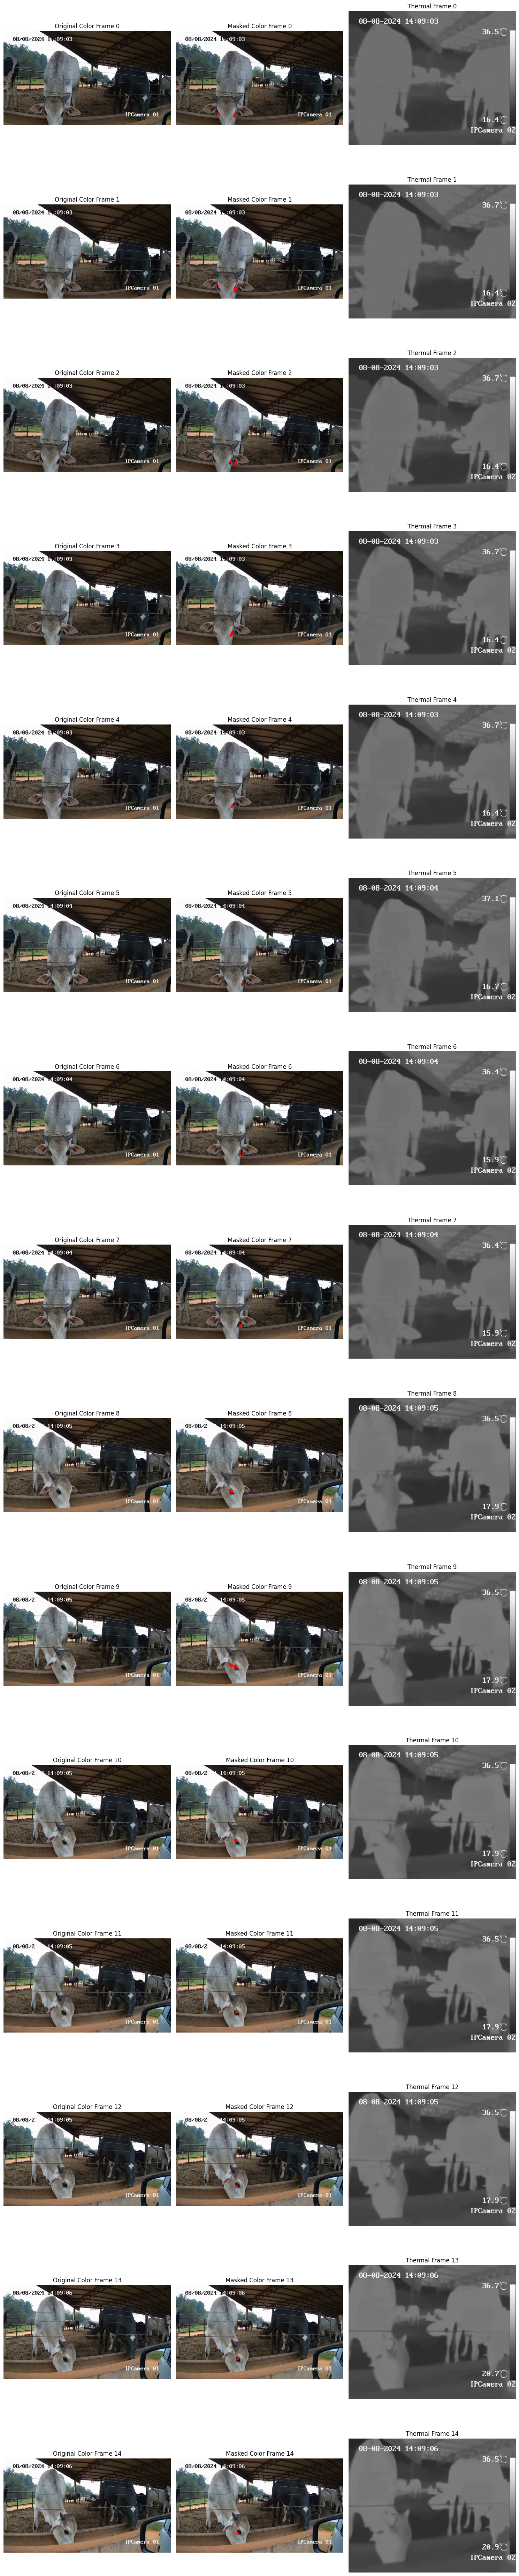

'\nif masked_frame_numbers is not None:\n    for i in range(min(5, len(masked_frame_numbers))):\n        frame_number = masked_frame_numbers[i]\n        color_frame = color_frames[frame_number]\n        thermal_frame = thermal_frames[frame_number]\n        masked_color_frame = masked_color_frames[i]\n        \n        # Salvar os frames para inspeção\n        cv2.imwrite(os.path.join(data_dir, f\'original_frame_{frame_number}.png\'), color_frame)\n        cv2.imwrite(os.path.join(data_dir, f\'masked_frame_{frame_number}.png\'), masked_color_frame)\n        cv2.imwrite(os.path.join(data_dir, f\'thermal_frame_{frame_number}.png\'), thermal_frame)\n        print(f"Frames de amostra salvos para frame_number {frame_number}")\nelse:\n    print("Não há uma lista de frame numbers. Salvar frames de amostra não está disponível.")\n'

In [12]:
# 3.5. Definir o intervalo de frames a serem visualizados
START = 0   # Índice inicial (0-based)
END = 15     # Índice final (não incluso)
RESIZE_FACTOR = 0.5  # Fator de redimensionamento (opcional)

# Verificar se END não excede o total de frames mascarados
END = min(END, len(masked_color_frames))

# 3.6. Visualizar os frames
visualize_frames(
    color_frames=color_frames,
    masked_color_frames=masked_color_frames,
    thermal_frames=thermal_frames,
    masked_frame_numbers=masked_frame_numbers,
    start=START,
    end=END,
    resize_factor=RESIZE_FACTOR
)

# 3.7. (Opcional) Salvar Frames de Amostra para Verificação Manual
# Se você tiver a lista de frame numbers, pode salvar os frames para inspeção
# Descomente e ajuste conforme necessário
"""
if masked_frame_numbers is not None:
    for i in range(min(5, len(masked_frame_numbers))):
        frame_number = masked_frame_numbers[i]
        color_frame = color_frames[frame_number]
        thermal_frame = thermal_frames[frame_number]
        masked_color_frame = masked_color_frames[i]
        
        # Salvar os frames para inspeção
        cv2.imwrite(os.path.join(data_dir, f'original_frame_{frame_number}.png'), color_frame)
        cv2.imwrite(os.path.join(data_dir, f'masked_frame_{frame_number}.png'), masked_color_frame)
        cv2.imwrite(os.path.join(data_dir, f'thermal_frame_{frame_number}.png'), thermal_frame)
        print(f"Frames de amostra salvos para frame_number {frame_number}")
else:
    print("Não há uma lista de frame numbers. Salvar frames de amostra não está disponível.")
"""